# Homework 2: Bayes Optimal Classifiers

- Name: Congxin (David) Xu
- Computing ID: cx2rx

### Honor Pledge: 
I have neither given nor received aid on this assignment.

### Question 1
The authors in [1] describe a marketing campaign by a bank in Portugal. Modify the `Exercise3.2LDAQDA_IrisSoution` python code to use the data (`bank-full.csv`) from this marketing campaign with only the predictor variables `age`, `balance`, and `duration` and the response variable, `y`, to create the Bayes optimal classifiers for each of the conditions listed below. Provide your python code for each of these cases.

(a) Assume Gaussian class conditional likelihoods with unequal  variance-covariance matrices with each of the following additional assumptions
applied singularly to each decision rule in this class:

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Read in the data
data = pd.read_csv("bank-full.csv")
data['Class'] = data['y']
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,Class
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,no


In [3]:
data_1a = data[['age', 'balance', 'duration', 'Class']]
data_1a.head()

,age,balance,duration,Class
0,58,2143,261,no
1,44,29,151,no
2,33,2,76,no
3,47,1506,92,no
4,33,1,198,no


In [4]:
def multivariate_gaussian_pdf(X, MU, SIGMA):
    """Code from Data Blog https://xavierbourretsicotte.github.io/MLE_Multivariate_Gaussian.html
    Maximum Likelihood Estimator: Multivariate Gaussian Distribution
        by Xavier Bourret Sicotte, Fri 22 June 2018
    Returns the pdf of a multivariate Gaussian distribution
     - X, MU are p x 1 vectors
     - SIGMA is a p x p matrix"""
    # Initialize and reshape
    X = X.reshape(-1, 1)
    MU = MU.reshape(-1, 1)
    p, _ = SIGMA.shape

    # Compute values
    SIGMA_inv = np.linalg.inv(SIGMA)
    denominator = np.sqrt((2 * np.pi) ** p * np.linalg.det(SIGMA))
    exponent = -(1 / 2) * ((X - MU).T @ SIGMA_inv @ (X - MU))

    # Return result
    return float((1. / denominator) * np.exp(exponent))

class QDA:
    """Creates a class for Quadratic Discriminant Analysis
    Input:
        data = pandas data frame for a csv file, must have one column labeled "Class" and the rest numeric data
    Methods:
        compute_probabilities = given an input observation computes the likelihood for each class and the GML class
        compute_probabilities: given an input observation and prior probabilities,
            computes the posterior probabilities for each class and most probable class"""

    def __init__(self, data):
        # reads the data and computes the statistics needed for classification

        # read the iris data as a Pandas data frame
        df = data

        # separate the class labels from the rest of the data
        # we are assuming the column name with class labels is 'Class'
        # and all other columns are numeric
        self.data_labels = df.loc[:]['Class']
        self.data = np.asarray(df.drop('Class', axis=1, inplace=False))

        # get information about the dimensions the data
        self.num_rows, self.num_cols = self.data.shape

        # get the class names as an array of strings
        self.class_names = np.unique(self.data_labels)

        # determine number of observations in each class
        self.num_obs = dict()
        for name in self.class_names:
            self.num_obs[name] = sum(self.data_labels == name)

        # compute the mean of each class
        self.means = dict()
        for name in self.class_names:
            self.means[name] = np.mean(self.data[self.data_labels == name, :], 0)

        # compute the covariance matrix of each class
        self.covs = dict()
        for name in self.class_names:
            self.covs[name] = np.cov(np.transpose(self.data[self.data_labels == name, :]))

    def compute_likelihoods(self, x):
        # compute and output the likelihood of each class and the maximum likelihood class

        # check that the input data x has the correct number of rows
        if not (len(x) == self.num_cols):
            print('Data vector has wrong number of values.')
            return -1

        # reformat x as a numpy array, incase the user input a list
        x = np.asarray(x)

        # compute the likelihood of each class
        likelihoods = np.zeros(len(self.class_names))
        idx = 0
        for name in self.class_names:
            likelihoods[idx] = multivariate_gaussian_pdf(x, self.means[name], self.covs[name])
            idx = idx + 1
        # get the indices for sorting the likelihoods (in descending order)
        indices_sorted = np.argsort(likelihoods)[::-1]

        # print the predicted class and all class likelihoods
        print('QDA Predicted Class: ' + self.class_names[indices_sorted[0]])
        print('QDA Class Likelihoods:')
        for idx in range(len(indices_sorted)):
            print(self.class_names[indices_sorted[idx]] + ': ' + str(likelihoods[indices_sorted[idx]]))

        # return the likelihoods
        return likelihoods

    def compute_probabilities(self, x, priors):
        # compute and output the probability of each class and the maximum probability class
        
        #likelihoods = self.compute_likelihoods(x)
        # check that the input data x has the correct number of rows
        if not (len(x) == self.num_cols):
            print('Data vector has wrong number of values.')
            return -1

        # reformat x as a numpy array, incase the user input a list
        x = np.asarray(x)

        # compute the likelihood of each class
        likelihoods = np.zeros(len(self.class_names))
        idx = 0
        for name in self.class_names:
            likelihoods[idx] = multivariate_gaussian_pdf(x, self.means[name], self.covs[name])
            idx = idx + 1
        
        #Number of classes
        Nclass = len(self.class_names)
        
        
        #posterior probabilties: likelihood * prior / normalize
        postprob = np.zeros(Nclass)
        idx = 0
        normalize = 0
        for name in self.class_names:
            proportion = likelihoods[idx] * priors[name]
            postprob[idx] = proportion
            normalize += proportion
            idx = idx + 1
        postprob = np.round(postprob / normalize,4)
        # get the indices for sorting the posterior probabilities (in descending order)
        indices_sorted = np.argsort(postprob)[::-1]
        
        
        print('QDA Predicted Class: ' + self.class_names[indices_sorted[0]])
        print('QDA Posterior Probabilities:')
        for idx in range(len(indices_sorted)):
            print(self.class_names[indices_sorted[idx]] + ': ' + str(postprob[indices_sorted[idx]]))

        # return the posterior probabilities
        return postprob

In [5]:
# Running the model
model_qda = QDA(data_1a)
observation = [47, 1506, 92]

#### i: Equal class priors and equal costs for misclassification

In [6]:
uninformative_priors = {
    "no": 1 / 2,
    "yes": 1 / 2
}
model_qda.compute_probabilities(observation, uninformative_priors)

QDA Predicted Class: no
QDA Posterior Probabilities:
no: 0.8071
yes: 0.1929


array([0.8071, 0.1929])

#### ii: The prior for not selecting the new bank service is 0.9 and misclassification costs are equal;

In [7]:
informative_priors = {
    "no": 0.9,
    "yes": 0.1
}
model_qda.compute_probabilities(observation, informative_priors)

QDA Predicted Class: no
QDA Posterior Probabilities:
no: 0.9741
yes: 0.0259


array([0.9741, 0.0259])

#### iii: The prior for not selecting the new bank service is 0.9 and the cost of classifying a customer as not a new service candidate when they are is 15 times the cost of classifying a customer as a new service customer

In [8]:
informative_priors = {
    "no": (0.9 * 1 / 16),
    "yes": (0.1 * 15 / 16)
}
model_qda.compute_probabilities(observation, informative_priors)

QDA Predicted Class: no
QDA Posterior Probabilities:
no: 0.7151
yes: 0.2849


array([0.7151, 0.2849])

(b) Assume Gaussian class conditional likelihoods with equal variancecovariance
matrices with each of the following additional assumptions
applied singularly to each decision rule in this class:

In [9]:
###########################
# LDA Code

def multivariate_gaussian_pdf(X, MU, SIGMA):
    """Code from Data Blog https://xavierbourretsicotte.github.io/MLE_Multivariate_Gaussian.html
    Maximum Likelihood Estimator: Multivariate Gaussian Distribution
        by Xavier Bourret Sicotte, Fri 22 June 2018
    Returns the pdf of a multivariate Gaussian distribution
     - X, MU are p x 1 vectors
     - SIGMA is a p x p matrix"""
    # Initialize and reshape
    X = X.reshape(-1, 1)
    MU = MU.reshape(-1, 1)
    p, _ = SIGMA.shape

    # Compute values
    SIGMA_inv = np.linalg.inv(SIGMA)
    denominator = np.sqrt((2 * np.pi) ** p * np.linalg.det(SIGMA))
    exponent = -(1 / 2) * ((X - MU).T @ SIGMA_inv @ (X - MU))

    # Return result
    return float((1. / denominator) * np.exp(exponent))


class LDA:
    """Creates a class for Linear Discriminant Analysis
    Input:
        data = pandas data frame name for a csv file, must have one column labeled "class" and the rest numeric data
    Methods:
        compute_probabilities = given an input observation computes the likelihood for each class and the GML class
        compute_probabilities: given an input observation and prior probabilities,
            computes the posterior probabilities for each class and most probable class"""

    def __init__(self, data):
        # reads the data and computes the statistics needed for classification

        # read the iris data as a Pandas data frame
        df = data

        # separate the class labels from the rest of the data
        # we are assuming the column name with class labels is 'Class'
        # and all other columns are numeric
        self.data_labels = df.loc[:]['Class']
        self.data = np.asarray(df.drop('Class', axis=1, inplace=False))

        # get information about the dimensions the data
        self.num_rows, self.num_cols = self.data.shape

        # get the class names as an array of strings
        self.class_names = np.unique(self.data_labels)

        # determine number of observations in each class
        self.num_obs = dict()
        for name in self.class_names:
            self.num_obs[name] = sum(self.data_labels == name)

        # compute the mean of each class
        self.means = dict()
        for name in self.class_names:
            self.means[name] = np.mean(self.data[self.data_labels == name, :], 0)

        # compute the mean covariance matrix
        self.cov = np.zeros([self.num_cols, self.num_cols])
        for name in self.class_names:
            self.cov = self.cov + self.num_obs[name] * np.cov(np.transpose(self.data[self.data_labels == name, :]))
        self.cov = self.cov / self.num_rows

    def compute_likelihoods(self, x):
        # compute and output the likelihood of each class and the maximum likelihood class

        # check that the input data x has the correct number of rows
        if not (len(x) == self.num_cols):
            print('Data vector has wrong number of values.')
            return -1

        # reformat x as a numpy array, incase the user input a list
        x = np.asarray(x)

        # compute the likelihood of each class
        likelihoods = np.zeros(len(self.class_names))
        idx = 0
        for name in self.class_names:
            likelihoods[idx] = multivariate_gaussian_pdf(x, self.means[name], self.cov)
            idx = idx + 1

        # get the indices for sorting the likelihoods (in descending order)
        indices_sorted = np.argsort(likelihoods)[::-1]

        # print the predicted class and all class likelihoods
        print('LDA Predicted Class: ' + self.class_names[indices_sorted[0]])
        print('LDA Class Likelihoods:')
        for idx in range(len(indices_sorted)):
            print(self.class_names[indices_sorted[idx]] + ': ' + str(likelihoods[indices_sorted[idx]]))

        # return the likelihoods
        return likelihoods

    def compute_probabilities(self, x, priors):
        # compute and output the probability of each class and the maximum probability class
        
        #likelihoods = self.compute_likelihoods(x)
        # check that the input data x has the correct number of rows
        if not (len(x) == self.num_cols):
            print('Data vector has wrong number of values.')
            return -1

        # reformat x as a numpy array, incase the user input a list
        x = np.asarray(x)

        # compute the likelihood of each class
        likelihoods = np.zeros(len(self.class_names))
        idx = 0
        for name in self.class_names:
            likelihoods[idx] = multivariate_gaussian_pdf(x, self.means[name], self.cov)
            idx = idx + 1
        
        #Number of classes
        Nclass = len(self.class_names)
        
        
        #posterior probabilties: likelihood * prior / normalize
        postprob = np.zeros(Nclass)
        idx = 0
        normalize = 0
        for name in self.class_names:
            proportion = likelihoods[idx] * priors[name]
            postprob[idx] = proportion
            normalize += proportion
            idx = idx + 1
        postprob = np.round(postprob / normalize, 4)
        # get the indices for sorting the posterior probabilities (in descending order)
        indices_sorted = np.argsort(postprob)[::-1]
        
        
        print('LDA Predicted Class: ' + self.class_names[indices_sorted[0]])
        print('LDA Posterior Probabilities:')
        for idx in range(len(indices_sorted)):
            print(self.class_names[indices_sorted[idx]] + ': ' + str(postprob[indices_sorted[idx]]))

        # return the posterior probabilities
        return postprob

In [10]:
# Running the model
model_lda = LDA(data_1a)
observation = [47, 1506, 92]

#### i: Equal class priors and equal costs for misclassification

In [11]:
uninformative_priors = {
    "no": 1 / 2,
    "yes": 1 / 2
}
model_lda.compute_probabilities(observation, uninformative_priors)

LDA Predicted Class: no
LDA Posterior Probabilities:
no: 0.8291
yes: 0.1709


array([0.8291, 0.1709])

#### ii: The prior for not selecting the new bank service is 0.9 and misclassification costs are equal;

In [12]:
informative_priors = {
    "no": 0.9,
    "yes": 0.1
}
model_lda.compute_probabilities(observation, informative_priors)

LDA Predicted Class: no
LDA Posterior Probabilities:
no: 0.9776
yes: 0.0224


array([0.9776, 0.0224])

#### iii: The prior for not selecting the new bank service is 0.9 and the cost of classifying a customer as not a new service candidate when they are is 15 times the cost of classifying a customer as a new service customer

In [13]:
informative_priors = {
    "no": (0.9 * 1 / 16),
    "yes": (0.1 * 15 / 16)
}
model_lda.compute_probabilities(observation, informative_priors)

LDA Predicted Class: no
LDA Posterior Probabilities:
no: 0.7444
yes: 0.2556


array([0.7444, 0.2556])

### Question 2
Use numpy and pandas to develop a Naive Bayes classifier for edible mushrooms with the data in `MushroomData.csv` and `MushroomVariables.txt`. Use $\frac{2}{3}$ of the observations to train the classifier and test on $\frac{1}{3}$. Submit your code and your testing results. Hint: Treat the observations as  documents and the features with their values as words in a similar manner to the approach used to classify restaurant reviews.

In [14]:
# Read in Column Nmaes
header = pd.read_csv("MushroomVariables.txt", sep=",", header = None)
header = list(header.values)

# Read in Data
data_2 = pd.read_csv("MushroomData.csv", header = None)
data_2.columns = header
data_2.head()

,edible_class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
1,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
2,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
3,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
4,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,BROWN,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS


In [15]:
# Split the train and test
np.random.seed(666)
split = np.random.rand(len(data_2)) < 2/3
train = data_2[split]
test = data_2[~split]

In [16]:
# Add Column Names to each of the values within that column
d_train = dict()
d_train['edible_class'] = list(train.iloc[:, 0])

for i in range(1, len(train.keys())):
    d_train[train.keys()[i][0]] = list(train.keys()[i][0] + "_" + train.iloc[:, i])
new_train = pd.DataFrame(data = d_train)

new_train.head()

,edible_class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,EDIBLE,cap-shape_CONVEX,cap-surface_SMOOTH,cap-color_WHITE,bruises_BRUISES,odor_ALMOND,gill-attachment_FREE,gill-spacing _CROWDED,gill-size_NARROW,gill-color_BROWN,...,stalk-surface-below-ring_SMOOTH,stalk-color-above-ring_WHITE,stalk-color-below-ring_WHITE,veil-type_PARTIAL,veil-color_WHITE,ring-number_ONE,ring-type_PENDANT,spore-print-color_BROWN,population_SEVERAL,habitat_WOODS
1,EDIBLE,cap-shape_CONVEX,cap-surface_SMOOTH,cap-color_WHITE,bruises_BRUISES,odor_ANISE,gill-attachment_FREE,gill-spacing _CROWDED,gill-size_NARROW,gill-color_WHITE,...,stalk-surface-below-ring_SMOOTH,stalk-color-above-ring_WHITE,stalk-color-below-ring_WHITE,veil-type_PARTIAL,veil-color_WHITE,ring-number_ONE,ring-type_PENDANT,spore-print-color_PURPLE,population_SEVERAL,habitat_WOODS
2,EDIBLE,cap-shape_CONVEX,cap-surface_SMOOTH,cap-color_WHITE,bruises_BRUISES,odor_ANISE,gill-attachment_FREE,gill-spacing _CROWDED,gill-size_NARROW,gill-color_WHITE,...,stalk-surface-below-ring_SMOOTH,stalk-color-above-ring_WHITE,stalk-color-below-ring_WHITE,veil-type_PARTIAL,veil-color_WHITE,ring-number_ONE,ring-type_PENDANT,spore-print-color_BROWN,population_SEVERAL,habitat_WOODS
3,EDIBLE,cap-shape_CONVEX,cap-surface_SMOOTH,cap-color_WHITE,bruises_BRUISES,odor_ANISE,gill-attachment_FREE,gill-spacing _CROWDED,gill-size_NARROW,gill-color_PINK,...,stalk-surface-below-ring_SMOOTH,stalk-color-above-ring_WHITE,stalk-color-below-ring_WHITE,veil-type_PARTIAL,veil-color_WHITE,ring-number_ONE,ring-type_PENDANT,spore-print-color_PURPLE,population_SEVERAL,habitat_WOODS
4,EDIBLE,cap-shape_CONVEX,cap-surface_SMOOTH,cap-color_WHITE,bruises_BRUISES,odor_ANISE,gill-attachment_FREE,gill-spacing _CROWDED,gill-size_NARROW,gill-color_PINK,...,stalk-surface-below-ring_SMOOTH,stalk-color-above-ring_WHITE,stalk-color-below-ring_WHITE,veil-type_PARTIAL,veil-color_WHITE,ring-number_ONE,ring-type_PENDANT,spore-print-color_BROWN,population_SEVERAL,habitat_WOODS


In [17]:
new_train.shape

(5597, 23)

In [18]:
# Add Column Names to each of the values within that column
d_test = dict()
d_test['edible_class'] = list(test.iloc[:, 0])

for i in range(1, len(test.keys())):
    d_test[test.keys()[i][0]] = list(test.keys()[i][0] + "_" + test.iloc[:, i])

new_test = pd.DataFrame(data = d_test)
new_test.head()

,edible_class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,EDIBLE,cap-shape_CONVEX,cap-surface_SMOOTH,cap-color_WHITE,bruises_BRUISES,odor_ALMOND,gill-attachment_FREE,gill-spacing _CROWDED,gill-size_NARROW,gill-color_WHITE,...,stalk-surface-below-ring_SMOOTH,stalk-color-above-ring_WHITE,stalk-color-below-ring_WHITE,veil-type_PARTIAL,veil-color_WHITE,ring-number_ONE,ring-type_PENDANT,spore-print-color_PURPLE,population_SEVERAL,habitat_WOODS
1,EDIBLE,cap-shape_CONVEX,cap-surface_SMOOTH,cap-color_WHITE,bruises_BRUISES,odor_ALMOND,gill-attachment_FREE,gill-spacing _CROWDED,gill-size_NARROW,gill-color_WHITE,...,stalk-surface-below-ring_SMOOTH,stalk-color-above-ring_WHITE,stalk-color-below-ring_WHITE,veil-type_PARTIAL,veil-color_WHITE,ring-number_ONE,ring-type_PENDANT,spore-print-color_BROWN,population_SEVERAL,habitat_WOODS
2,EDIBLE,cap-shape_CONVEX,cap-surface_SMOOTH,cap-color_WHITE,bruises_BRUISES,odor_ALMOND,gill-attachment_FREE,gill-spacing _CROWDED,gill-size_NARROW,gill-color_PINK,...,stalk-surface-below-ring_SMOOTH,stalk-color-above-ring_WHITE,stalk-color-below-ring_WHITE,veil-type_PARTIAL,veil-color_WHITE,ring-number_ONE,ring-type_PENDANT,spore-print-color_PURPLE,population_SEVERAL,habitat_WOODS
3,EDIBLE,cap-shape_CONVEX,cap-surface_SMOOTH,cap-color_WHITE,bruises_BRUISES,odor_ALMOND,gill-attachment_FREE,gill-spacing _CROWDED,gill-size_NARROW,gill-color_PINK,...,stalk-surface-below-ring_SMOOTH,stalk-color-above-ring_WHITE,stalk-color-below-ring_WHITE,veil-type_PARTIAL,veil-color_WHITE,ring-number_ONE,ring-type_PENDANT,spore-print-color_BROWN,population_SEVERAL,habitat_WOODS
4,EDIBLE,cap-shape_CONVEX,cap-surface_SMOOTH,cap-color_WHITE,bruises_BRUISES,odor_ALMOND,gill-attachment_FREE,gill-spacing _CROWDED,gill-size_NARROW,gill-color_BROWN,...,stalk-surface-below-ring_SMOOTH,stalk-color-above-ring_WHITE,stalk-color-below-ring_WHITE,veil-type_PARTIAL,veil-color_WHITE,ring-number_ONE,ring-type_PENDANT,spore-print-color_PURPLE,population_SEVERAL,habitat_WOODS


In [19]:
# For Topic = Edible
# Create a train document of words
train_edible_document = new_train[new_train['edible_class'] == 'EDIBLE']. \
    iloc[:, list(range(1,len(new_train.keys())))].values.ravel()
train_edible_document

array(['cap-shape_CONVEX', 'cap-surface_SMOOTH', 'cap-color_WHITE', ...,
       'spore-print-color_BUFF', 'population_CLUSTERED', 'habitat_LEAVES'],
      dtype=object)

In [20]:
# Count the number of features occured in training data for edible
train_edible_count = dict()
for i in train_edible_document:
    if i not in train_edible_count:
        train_edible_count[i] = 0
    else:
        train_edible_count[i] += 1
        
# Get the total number of words occured and number of unique features
edible_total = sum(train_edible_count.values())
edible_count = len(train_edible_count.keys())

# Define alpha 
alpha = 1.5

# Caculate the likelihood for each word in topic = edible
for index, value in enumerate(train_edible_count):
    train_edible_count[value] = (train_edible_count[value] + alpha) / \
          (edible_total + alpha * edible_count)

In [21]:
# For Topic = Poisonous
# Create a train document of words
train_poisonous_document = new_train[new_train['edible_class'] == 'POISONOUS']. \
    iloc[:, list(range(1,len(new_train.keys())))].values.ravel()
train_poisonous_document

array(['cap-shape_CONVEX', 'cap-surface_SMOOTH', 'cap-color_WHITE', ...,
       'spore-print-color_WHITE', 'population_CLUSTERED',
       'habitat_LEAVES'], dtype=object)

In [22]:
# Count the number of features occured in training data for Poisonous
train_poisonous_count = dict()
for i in train_poisonous_document:
    if i not in train_poisonous_count:
        train_poisonous_count[i] = 0
    else:
        train_poisonous_count[i] += 1
        
# Get the total number of words occured and number of unique features
poisonous_total = sum(train_poisonous_count.values())
poisonous_count = len(train_poisonous_count.keys())

# Caculate the likelihood for each word in topic = edible
for index, value in enumerate(train_poisonous_count):
    train_poisonous_count[value] = (train_poisonous_count[value] + alpha) / \
          (poisonous_total + alpha * poisonous_count)

In [23]:
# Calculate the Posterior Probability assuming equal prior = 0.5
new_test_edible_post = list()
new_test_poisonous_post = list()

for row in range(0, len(new_test)):
    edible_post = 1
    poisonous_post = 1
    for col in range(1, len(new_test.columns)):
        if (new_test.iloc[row, col] in train_edible_count): 
            edible_post = edible_post * \
            train_edible_count[new_test.iloc[row, col]]
        else:
            edible_post = edible_post * \
                (0 + alpha) / (edible_total + alpha * edible_count)
        
        if (new_test.iloc[row, col] in train_poisonous_count): 
            poisonous_post = poisonous_post * \
                train_poisonous_count[new_test.iloc[row, col]]
        else:
            poisonous_post = poisonous_post * \
                (0 + alpha) / (poisonous_total + alpha * poisonous_count)

    new_test_edible_post = new_test_edible_post + [edible_post]   
    new_test_poisonous_post = new_test_poisonous_post + [poisonous_post]

In [24]:
actual = list()
predict = list()
for i in range(0, len(new_test)):
    if new_test.iloc[i,0] == 'EDIBLE':
        actual += [1]
    else:
        actual += [0]
        
    if new_test_edible_post[i] > new_test_poisonous_post[i]:
        predict += [1]
    else:
        predict += [0]

df_confusion = pd.crosstab(pd.Series(actual, name='actual'), pd.Series(predict, name='predict'))    
df_confusion

predict,0,1
actual,,
0,1172,138
1,8,1502


The total accuracy for the Naive Bayes Model is $$\frac{ 1172 + 1502}{1172 + 1502 + 8 + 138} = 94.82\%$$

### Question 3: 
Implement in python a Bayesian generalized least squares approach
to fit the model:
$$y = \phi_0 + \phi_1 x + \phi_2 \sqrt{x} + \phi_3 log(x) + \phi_4 x^3 + \eta$$
where the true generating model has $\phi$ = (-1.7, -0.1, 3.2, 0.7, -0.8). Assume you know the true basis functions but not the coefficients. Also assume the model variance-covariance is $\sigma_\eta I$ , where $\sigma_\eta$ is constant. Similarly, assume the prior is Gaussian with parameters, $\mu_{prior}$ = (1, 1, 1, 1, 1, 1) and variance-covariance is  $\sigma_\theta I$. 
- Compare the results from predicting 20 new values with two different values each for  $\sigma_\eta$ and  $\sigma_\theta$ and three different values for N producing 12 total simulation runs. 
- Explain the differences you observe in graphical presentations of the predictions with error bars plotted with the actual model generating the data. Submit your code and your results.

In [25]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

def plot_Bayesian_GLM(model_eta, model_theta, N, plot):
    # Number and range of training samples
    # N = 500
    x_min = 0.1
    x_max = 2

    # sigma eta and sigma theta 
    # variance_input = [0.5, 0.01]

    # Variance for the noise, eta
    variance_eta = model_eta
    std_eta = np.sqrt(variance_eta)

    # Set random or true theta parameters for the ground truth equation
    theta_true = np.array([-1.7, -0.1, 3.2, 0.7, -0.8])
    theta_distrbd = np.array([1, 1, 1, 1, 1])
    l = len(theta_true)

    # Parameters for gaussian prior
    # Variance for the prior
    variance_theta = model_theta
    sigma_theta = np.sqrt(variance_theta)
    mu_theta_prior = theta_true # or mu_theta_prior = theta_distrbd

    # Number of samples for prediction
    Np = 20

    # Generate training samples
    x = np.linspace(x_min, x_max, N, endpoint=False)

    # Generate random eta
    eta = np.random.normal(0, std_eta, N)

    # Measurement matrix
    phi = np.array([np.ones_like(x), x, np.sqrt(x), np.log(x), np.power(x,3)]).T

    # Generate observations with eta
    y = np.matmul(phi, theta_true) + eta

    # Covariance matrix of Gaussian posterior
    temp = np.power(variance_theta, -1) * np.eye(l) + np.matmul(phi.T, phi) * np.power(variance_eta, -1)
    sigma_theta_pos = np.linalg.inv(temp)

    # Posterior mean
    mu_theta_pos =  mu_theta_prior + np.dot(np.power(variance_eta, -1) * (sigma_theta_pos), 
                                            np.dot(phi.T, (y - np.dot(phi, mu_theta_prior))))

    # Generate sample for predictions
    x_pred = (x_max - x_min) * np.random.random(Np)

    # Prediction measurement matrix, need to change here
    phi_pred = np.array([np.ones_like(x_pred), x_pred, np.sqrt(x_pred), np.log(x_pred), np.power(x_pred,3)]).T

    # Predicted mean
    mu_y_pred = np.dot(phi_pred, mu_theta_pos)

    # Predicted variance
    temp = np.power(variance_theta, -1) * np.eye(l) + np.matmul(phi_pred.T, phi_pred) * np.power(variance_eta, -1)
    sigma_theta_pos_pred = np.linalg.inv(temp)
    sigma_y_pred = variance_eta + np.dot(np.dot(phi_pred, sigma_theta_pos_pred), phi_pred.T)

    # Plot ground truth and results

    x_true = np.linspace(x_min, x_max, 5000, endpoint=False) 
    phi_true = np.array([np.ones_like(x_true), x_true, np.sqrt(x_true), np.log(x_true), np.power(x_true,3)]).T 
    y_true = np.dot(phi_true, theta_true)


    # plot.figure(figsize=(3,3))
    plot.plot(x_true,y_true, 'blue')
    plot.scatter(x_pred, mu_y_pred, marker='*', c='blue')
    plot.errorbar(x_pred,mu_y_pred, yerr=np.diag(sigma_y_pred), linestyle='None', c='red', linewidth=1)
    plot.set_title('N='+ str(N) + ", $\sigma_{\eta}$="+ str(model_eta) + \
                   ", $\sigma_{\u03B8}=$" + str(model_theta), pad=3)
    
    return(plt)

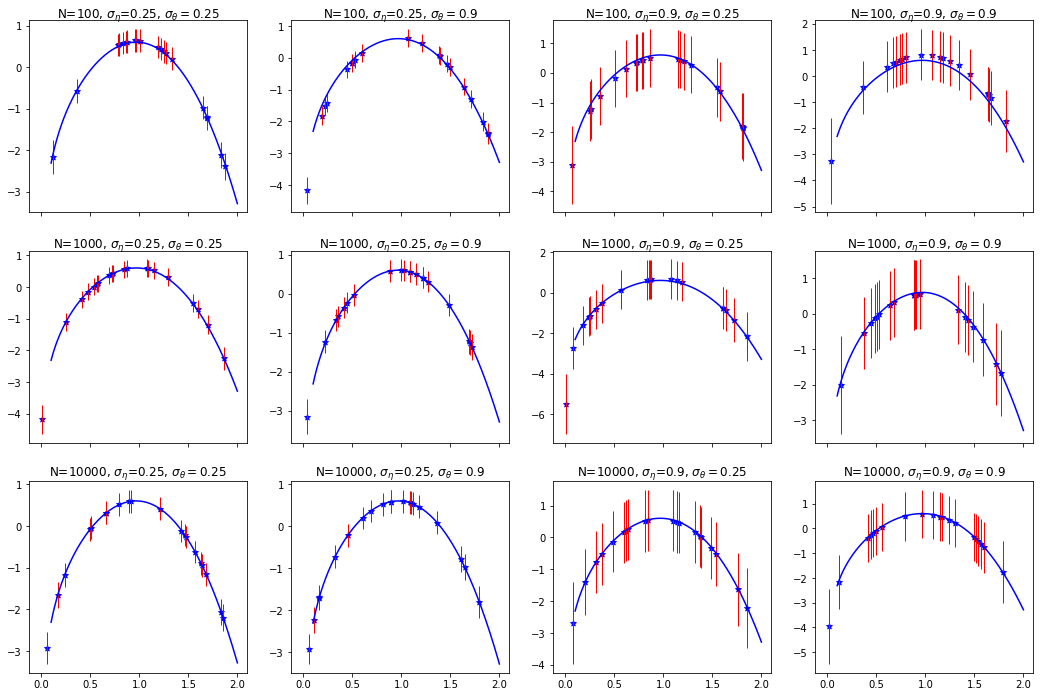

In [29]:
# Plot the 12 simulations
fig, axs = plt.subplots(nrows = 3, ncols = 4, sharex = True, figsize = (18, 12))
axs = trim_axs(axs, 12)
i = 0
for N in [100, 1000, 10000]:
    for eta in [0.25, 0.9]:
        for theta in [0.25, 0.9]:        
            plot_Bayesian_GLM(eta, theta, N, axs[i])
            i += 1

**Findings**
- Based on the 12 simulation plots above, we can see that as the number of sample size increases, the prediction accuracy also increases, as we see that the X dots sit right on top of the actual (blue) line.
- As $\sigma_\eta$ increases, we see that the error bar of each prediction also increases
- Changing the value of $\sigma_\theta$ does not dramatically influence the prediction value or the error bar.